In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import time
import os

In [2]:
!pip install kaggle

# Upload kaggle.json file (API key)
from google.colab import files
# https://www.kaggle.com/docs/api => Authentication to retrieve API key
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip cifake-real-and-ai-generated-synthetic-images.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  inflating:

In [3]:
# Load data
train_data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder('train', transform=train_data_transform)
test_data = datasets.ImageFolder('test', transform=test_data_transform)

# Split train data into 80% train / 20% validation
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

for images, labels in train_loader:
  print("Image batch shape:", images.shape)
  print("Label batch shape:", labels.shape)
  break

Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])


In [4]:
# Print the number of samples in the train and test sets
print('Number of training samples:', len(train_data))
print('Number of validation samples:', len(val_data))
print('Number of testing samples:', len(test_data))

Number of training samples: 80000
Number of validation samples: 20000
Number of testing samples: 20000


In [11]:
'''
Changes made to the original MLP code to attempt to increase testing accuracy:

1.  MLP Architecture:
- Increased the number of hidden layers from 2 to 3.
- Increased the number of nodes in the first hidden layer from 128 to 512.
- Increased the number of nodes in the second hidden layer from 64 to 256.
- Added a third hidden layer with 128 nodes.
- Added an additional dropout layer after the new third hidden layer.
- Adjusted the input size of the final linear layer to match the output of the preceding layer.

2.  Hyperparameters:
- Increased the number of training epochs from 10 to 15.

'''

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, num_classes=2):
        super(MLP, self).__init__()
        # Flattened image input: 3 color channels * 32 height * 32 width = 3072
        self.fc1 = nn.Linear(3 * 32 * 32, 512) # Increased nodes
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256) # Added a hidden layer and increased nodes
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 128) # Added another hidden layer and increased nodes
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5) # Added dropout

        self.fc4 = nn.Linear(128, num_classes) # Output layer, adjusted input size


    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32) # Flatten the image
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.dropout3(self.relu3(self.fc3(x)))
        x = self.fc4(x)
        return x

# Set device to CPU to avoid CUDA issues if necessary
device = torch.device("cpu") # Changed to prioritize CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Original line

model = MLP().to(device)
print(f"Using device {device} for training.")
print("Model initialized.")

Using device cpu for training.
Model initialized.


In [6]:
# Hyperparameters
num_epochs = 15 # Increased from 10
batch_size = 64
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Training loop
epoch_train_losses = []
epoch_train_accuracies = []
epoch_val_losses = []
epoch_val_accuracies = []
start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs} training...")
    epoch_start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    epoch_train_losses.append(train_loss / len(train_data))
    epoch_train_accuracies.append(100 * train_correct / len(train_data))


    # Validation
    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()

    epoch_val_losses.append(val_loss / len(val_data))
    epoch_val_accuracies.append(100 * val_correct / len(val_data))

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_train_losses[-1]:.4f}, Train Acc: {epoch_train_accuracies[-1]:.2f}%, Val Loss: {epoch_val_losses[-1]:.4f}, Val Acc: {epoch_val_accuracies[-1]:.2f}%, Time: {epoch_time:.2f}s")

end_time = time.time()
total_time = end_time - start_time
print(f"Training finished. Total time: {total_time:.2f}s")


Epoch 1/15 training...
Epoch 1/15 - Train Loss: 0.5571, Train Acc: 71.36%, Val Loss: 0.5005, Val Acc: 75.55%, Time: 80.28s
Epoch 2/15 training...
Epoch 2/15 - Train Loss: 0.5212, Train Acc: 74.35%, Val Loss: 0.4742, Val Acc: 77.28%, Time: 75.20s
Epoch 3/15 training...
Epoch 3/15 - Train Loss: 0.5075, Train Acc: 75.58%, Val Loss: 0.4797, Val Acc: 77.34%, Time: 74.88s
Epoch 4/15 training...
Epoch 4/15 - Train Loss: 0.5011, Train Acc: 76.02%, Val Loss: 0.4754, Val Acc: 77.47%, Time: 73.51s
Epoch 5/15 training...
Epoch 5/15 - Train Loss: 0.4954, Train Acc: 76.36%, Val Loss: 0.4788, Val Acc: 78.08%, Time: 73.70s
Epoch 6/15 training...
Epoch 6/15 - Train Loss: 0.4943, Train Acc: 76.58%, Val Loss: 0.4880, Val Acc: 76.90%, Time: 74.92s
Epoch 7/15 training...
Epoch 7/15 - Train Loss: 0.4864, Train Acc: 76.79%, Val Loss: 0.4617, Val Acc: 78.59%, Time: 73.90s
Epoch 8/15 training...
Epoch 8/15 - Train Loss: 0.4826, Train Acc: 77.20%, Val Loss: 0.4594, Val Acc: 78.72%, Time: 74.00s
Epoch 9/15 train

In [8]:
# Save model checkpoint
ckpt_dir = "model_checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
timestamp = time.strftime("%Y%m%d_%H%M%S", time.localtime())
filename = f"mlp_checkpoint_{timestamp}_valacc_{epoch_val_accuracies[-1]:.2f}.pt"
filepath = os.path.join(ckpt_dir, filename)
torch.save(model.state_dict(), filepath)
print(f"Saved checkpoint: {filepath}")

Saved checkpoint: model_checkpoints/mlp_checkpoint_20250422_025123_valacc_79.41.pt


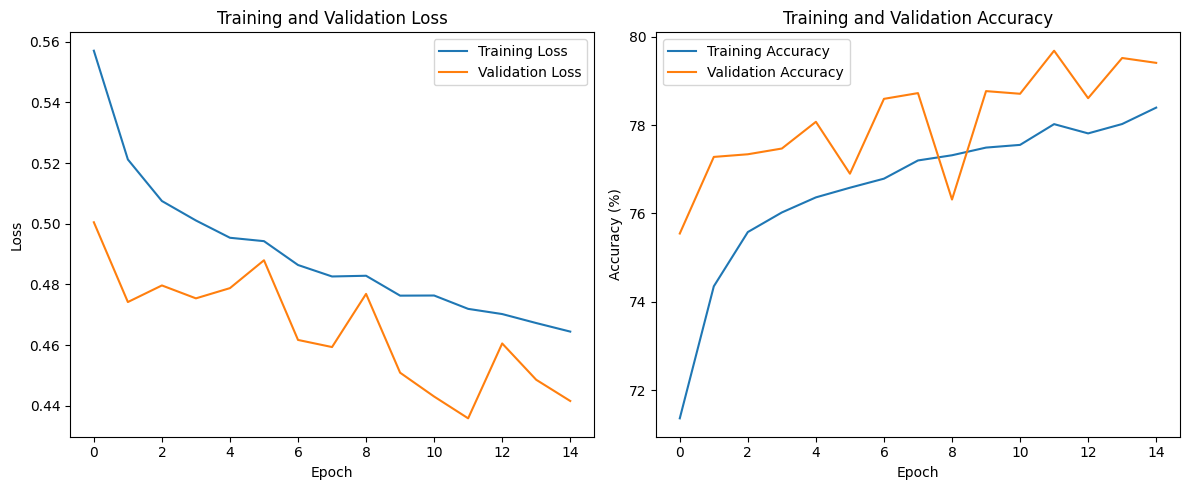

In [9]:
# Plot training and validation losses and accuracies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_accuracies, label='Training Accuracy')
plt.plot(epoch_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Evaluate model on test data
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')

Accuracy of the network on the test images: 79.56 %
